# **Statistical Modelling of the dark matter halo around M31**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import scipy.optimize as optimize
from scipy.special import iv, kv
from scipy.integrate import quad

In [2]:
import emcee
import corner
import time

## Reading data from Excel CSV file and plotting rotation curves for M31

In [4]:
csv_data_file = r'C:\Users\SCT\Downloads\M31_Grand_Rotation_Curve.csv'
df = pd.read_csv(csv_data_file)
df.dropna(how='any',inplace=True)

R_array = df['R (kpc)'].to_numpy()
sigma_R_array = df['R error (kpc)'].to_numpy()
v_array = df['Vc (km/s)'].to_numpy()
sigma_v_array = df['Vc error (km/s)'].to_numpy()

print(R_array)
print(sigma_R_array)
print(v_array)
print(sigma_v_array)

[1.000000e-01 1.200000e-01 1.440000e-01 1.730000e-01 2.070000e-01
 2.490000e-01 2.990000e-01 3.580000e-01 4.300000e-01 5.160000e-01
 6.190000e-01 7.430000e-01 8.920000e-01 1.070000e+00 1.284000e+00
 1.541000e+00 1.849000e+00 2.219000e+00 2.662000e+00 3.195000e+00
 3.834000e+00 4.601000e+00 5.521000e+00 6.625000e+00 7.950000e+00
 9.540000e+00 1.144800e+01 1.373700e+01 1.648400e+01 1.978100e+01
 2.373800e+01 2.848500e+01 3.418200e+01 4.101900e+01 4.922200e+01
 5.906700e+01 7.088000e+01 8.505600e+01 1.020680e+02 1.224810e+02
 1.469770e+02 1.763730e+02 2.116470e+02 2.539770e+02 3.047720e+02
 3.657270e+02 4.388720e+02 5.266470e+02 6.319760e+02 7.583710e+02
 9.100460e+02 1.092055e+03 1.310466e+03 1.572559e+03 1.887071e+03]
[ 0.    12.191 21.808  4.2    3.258  3.19   2.623  1.371  1.259  1.961
  5.126  8.621 11.225 22.146 23.299 20.013 18.476 12.065  5.51   3.016
  5.991  7.494  6.397  5.252  3.929  2.828  2.129  1.772  1.975  1.989
  1.58   2.106  3.826  9.815 23.924 26.447 24.657 27.258 29.

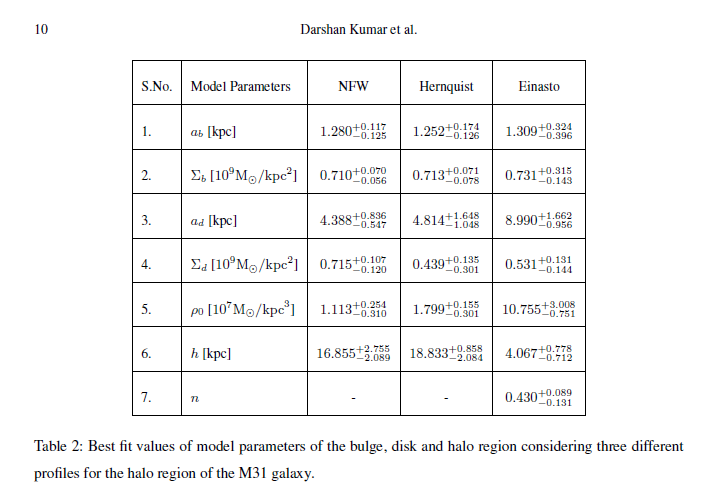

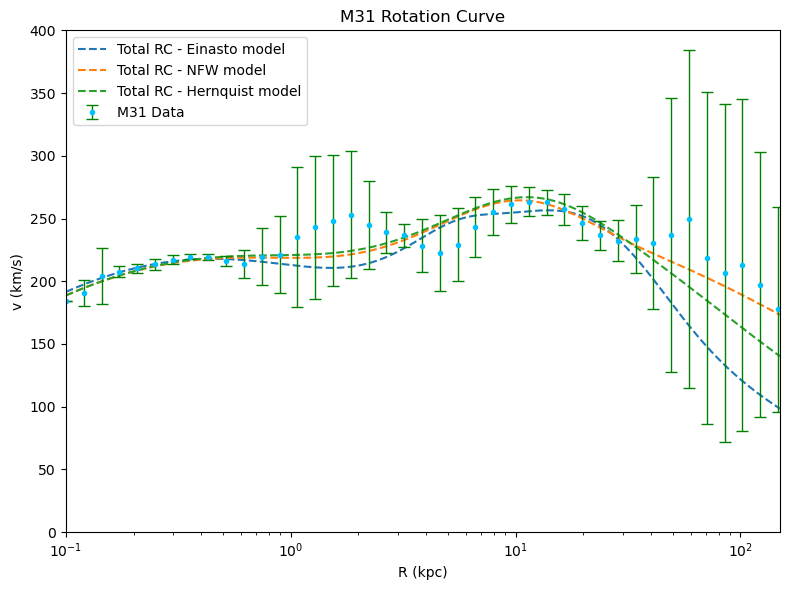

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

#Best fit parameter values for Einasto model
Σb_einasto_best = 0.731e9
a_b_einasto_best = 1.309
Σd_einasto_best = 0.531e9
a_d_einasto_best = 8.990
ρ0_einasto_best = 10.755e7
h_einasto_best = 4.067
n_einasto_best = 0.430

#Best fit parameter values for NFW model
Σb_nfw_best = 0.710e9
a_b_nfw_best = 1.280
Σd_nfw_best = 0.715e9
a_d_nfw_best = 4.388
ρ0_nfw_best = 1.113e7
h_nfw_best = 16.855

#Best fit parameter values for Hernquist model
Σb_hernquist_best = 0.713e9
a_b_hernquist_best = 1.252
Σd_hernquist_best = 0.439e9
a_d_hernquist_best = 4.814
ρ0_hernquist_best = 1.799e7
h_hernquist_best = 18.833

R_vals = np.logspace(np.log10(0.1), np.log10(150), 500)

#Einasto model
vth_array_einasto = [vth_tot_einasto(r, Σb_einasto_best, a_b_einasto_best, Σd_einasto_best, a_d_einasto_best, ρ0_einasto_best, h_einasto_best, n_einasto_best) for r in R_vals]
ax.plot(R_vals, vth_array_einasto, label = f"Total RC - Einasto model", ls='--')

#NFW model
vth_array_nfw = [vth_tot_nfw(r, Σb_nfw_best, a_b_nfw_best, Σd_nfw_best, a_d_nfw_best, ρ0_nfw_best, h_nfw_best) for r in R_vals]
ax.plot(R_vals, vth_array_nfw, label = f"Total RC - NFW model", ls='--')

#Hernquist model
vth_array_hernquist = [vth_tot_hernquist(r, Σb_hernquist_best, a_b_hernquist_best, Σd_hernquist_best, a_d_hernquist_best, ρ0_hernquist_best, h_hernquist_best) for r in R_vals]
ax.plot(R_vals, vth_array_hernquist, label = f"Total RC - Hernquist model", ls='--')


ax.errorbar(R_array, v_array, sigma_v_array, color='deepskyblue', ecolor='green', fmt='.', elinewidth=1, capsize=4, label='M31 Data')
ax.set_xscale('log')
ax.set_title('M31 Rotation Curve')
ax.set_xlabel('R (kpc)')
ax.set_ylabel('v (km/s)')
ax.set_xlim(0.1, 150)
ax.set_ylim(0, 400)
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig("M31 Rotation Curve", dpi=300, bbox_inches = 'tight')

# **Defining bulge, disk and halo velocities**

# **Einasto Profile**

## **Bulge**

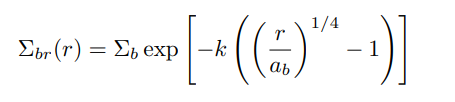

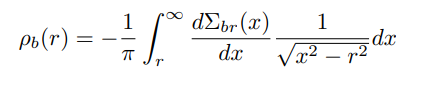

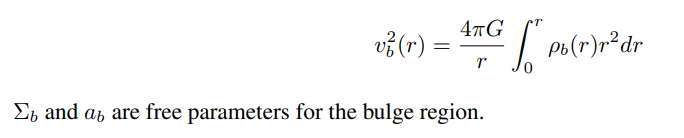

In [7]:
k = 7.6695
G = 4.302e-6  # (kpc * km^2) / (Msun * s^2)

def Σbr_x(x, Σb_einasto, a_b_einasto):
    return Σb_einasto * np.exp(-k * ((x / a_b_einasto)**0.25 - 1))

def dΣbr_x_dx(x, Σb_einasto, a_b_einasto):
    prefactor = -(k / 4) * (1 / a_b_einasto)**0.25 * x**(-0.75)
    return prefactor * Σbr_x(x, Σb_einasto, a_b_einasto)

def ρb_r_einasto(r, Σb_einasto, a_b_einasto):
    def integrand_ρb_r(u):
        x = r * np.cosh(u)
        return dΣbr_x_dx(x, Σb_einasto, a_b_einasto)
    integral, _ = quad(integrand_ρb_r, 1e-2, 20)
    return -integral / np.pi
    
def vb_einasto(r, Σb_einasto, a_b_einasto):
    def integrand_vb2_r(r_):
        return ρb_r_einasto(r_, Σb_einasto, a_b_einasto) * r_**2

    integral, _ = quad(integrand_vb2_r, 1e-2, r)
    vb2 = (4 * np.pi * G / r) * integral
    if not np.isfinite(vb2) or vb2 <= 0:
        return np.nan
    return np.sqrt(vb2)

## **Disk**

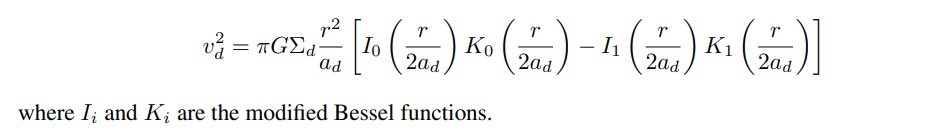

In [9]:
G = 4.302e-6  # (kpc * km^2) / (Msun * s^2)

def vd_einasto(r, Σd_einasto, a_d_einasto):
    y = r / (2 * a_d_einasto)
    constant = np.pi * G * Σd_einasto * (r**2 / a_d_einasto)
    bessel_term = iv(0, y) * kv(0, y) - iv(1, y) * kv(1, y)
    vd2 = constant * bessel_term
    if not np.isfinite(vd2) or vd2 <= 0:
        return np.nan
    return np.sqrt(vd2)

## **Dark matter halo - Einasto Model**

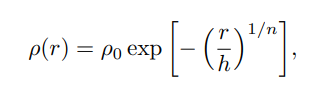

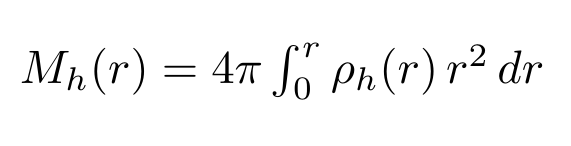

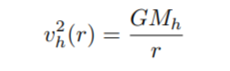

In [11]:
G = 4.302e-6  # (kpc * km^2) / (Msun * s^2)

def ρh_r_einasto(r, ρ0_einasto, h_einasto, n_einasto):
    return ρ0_einasto * np.exp(-(r / h_einasto)**(1 / n_einasto))
  
def Mh_r_einasto(r, ρ0_einasto, h_einasto, n_einasto):
    def integrand_Mh_r(r_):
        return ρh_r_einasto(r_, ρ0_einasto, h_einasto, n_einasto) * r_**2
        
    integral, _ = quad(integrand_Mh_r, 1e-2, r)
    return 4 * np.pi * integral
    
def vh_einasto(r, ρ0_einasto, h_einasto, n_einasto):
    vh2 = G * Mh_r_einasto(r, ρ0_einasto, h_einasto, n_einasto) / r
    if not np.isfinite(vh2) or vh2 <= 0:
        return np.nan
    return np.sqrt(vh2)

## Total theoretical velocity - Einasto model

In [13]:
def vth_tot_einasto(r, Σb_einasto, a_b_einasto, Σd_einasto, a_d_einasto, ρ0_einasto, h_einasto, n_einasto):
    vb_val = vb_einasto(r, Σb_einasto, a_b_einasto)
    vd_val = vd_einasto(r, Σd_einasto, a_d_einasto)
    vh_val = vh_einasto(r, ρ0_einasto, h_einasto, n_einasto)
    if not all(np.isfinite([vb_val, vd_val, vh_val])):
        return np.nan
    return np.sqrt(vb_val**2 + vd_val**2 + vh_val**2)

## **Using Bayesian Statistics**

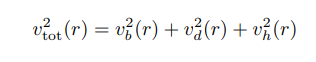

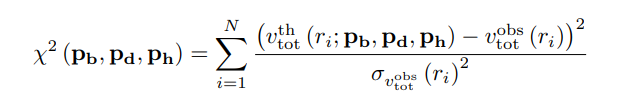

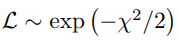

In [ ]:
def log_likelihood_einasto(R_array, v_array, sigma_v_array, Σb_einasto, a_b_einasto, Σd_einasto, a_d_einasto, ρ0_einasto, h_einasto, n_einasto):
    vth = np.array([vth_tot_einasto(ri, Σb_einasto, a_b_einasto, Σd_einasto, a_d_einasto, ρ0_einasto, h_einasto, n_einasto) for ri in R_array])
    if not np.all(np.isfinite(vth)):
        return -np.inf
    a = (vth - v_array) / sigma_v_array
    return -(1/2) * np.sum(a**2)

In [ ]:
def uniform_priors_einasto(Σb_einasto, a_b_einasto, Σd_einasto, a_d_einasto, ρ0_einasto, h_einasto, n_einasto):
    if 0.5 < a_b_einasto < 2.0 and 0.5e9 < Σb_einasto < 1.5e9 and 7 < a_d_einasto < 12 and 0.2e9 < Σd_einasto < 0.8e9 and 9e7 < ρ0_einasto < 11e7 and 1 < h_einasto < 6 and 0.2 < n_einasto < 0.8:
        return 0.0
    return -np.inf

In [ ]:
def log_posterior_einasto(theta):
    Σb_einasto, a_b_einasto, Σd_einasto, a_d_einasto, ρ0_einasto, h_einasto, n_einasto = theta
    lp = uniform_priors_einasto(Σb_einasto, a_b_einasto, Σd_einasto, a_d_einasto, ρ0_einasto, h_einasto, n_einasto)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_einasto(R_array, v_array, sigma_v_array, Σb_einasto, a_b_einasto, Σd_einasto, a_d_einasto, ρ0_einasto, h_einasto, n_einasto)
    return lp + ll

In [ ]:
def chi2_einasto(theta):
    Σb_einasto, a_b_einasto, Σd_einasto, a_d_einasto, ρ0_einasto, h_einasto, n_einasto = theta
    return -2 * log_posterior_einasto(theta)

## Running the optimiser

In [ ]:
initial_guesses_einasto = [0.731e9, 1.309, 0.531e9, 8.990, 10.755e7, 4.067, 0.430]
result = optimize.minimize(chi2_einasto, initial_guesses_einasto, method='nelder-mead',options={'maxiter':10000,'xatol': 1e-8, 'disp': True})

In [ ]:
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

## MCMC using emcee

In [ ]:
ndimension = 7
no_of_walkers = 40
no_of_steps_per_walker = 5000
burn_in_steps = 500

In [ ]:
initial_pos_of_walker = [result.x + 1e-4*np.random.randn(ndimension) for i in range(no_of_walkers)]        #randn gives samples from SND
print(initial_pos_of_walker)

In [ ]:
sampler = emcee.EnsembleSampler(no_of_walkers, ndimension, log_posterior_einasto, a=2)
print(sampler)

In [ ]:
sampler.run_mcmc(initial_pos_of_walker, no_of_steps_per_walker, rstate0=np.random.get_state(),progress=True);     #progress for progress bar

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,0]       # Samples of Σb from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to Σb for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to Σb", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,1]       # Samples of a_b from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)
    
ax.set_title(f"Markov Chains corresponding to a_b for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to a_b", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,2]       # Samples of Σd from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to Σd for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to Σd", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,3]       # Samples of a_d from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to a_d for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to a_d", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,4]       # Samples of ρ0 from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to ρ0 for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to ρ0", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,5]       # Samples of h from walker i
  l = len(a)
  n = list(range(l))
  plt.plot(n,a)

ax.set_title(f"Markov Chains corresponding to h for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to h", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,6]       # Samples of n from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to n for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to n", dpi=300, bbox_inches = 'tight')

## Corner plots

In [ ]:
samples = sampler.chain[:, burn_in_steps:, :].reshape((-1, ndimension))

In [ ]:
samples = sampler.chain[:, burn_in_steps:, :].reshape((-1, ndimension))

param_labels = [r"$\Sigma_b$", r"$a_b$", r"$\Sigma_d$", r"$a_d$", r"$\rho_0$", r"$h$", r"$n$"]
fig = corner.corner(samples, bins=50, labels=param_labels,
                    color="red",
                    quantiles=[0.16, 0.5, 0.84],
                    plot_contours=True,
                    fill_contours=True,
                    levels=(0.68, 0.95, 0.99),
                    plot_datapoints=True,
                    smooth=True, smooth1d=True,
                    title_fmt=".2g",
                    show_titles=True)

plt.show()
fig.savefig("Corner plot", dpi=300, bbox_inches='tight')

# **NFW Profile**

## **Bulge**

In [15]:
k = 7.6695
G = 4.302e-6  # (kpc * km^2) / (Msun * s^2)

def Σbr_x(x, Σb_nfw, a_b_nfw):
    return Σb_nfw * np.exp(-k * ((x / a_b_nfw)**0.25 - 1))

def dΣbr_x_dx(x, Σb_nfw, a_b_nfw):
    prefactor = -(k / 4) * (1 / a_b_nfw)**0.25 * x**(-0.75)
    return prefactor * Σbr_x(x, Σb_nfw, a_b_nfw)

def ρb_r_nfw(r, Σb_nfw, a_b_nfw):
    def integrand_ρb_r(u):
        x = r * np.cosh(u)
        return dΣbr_x_dx(x, Σb_nfw, a_b_nfw)
    integral, _ = quad(integrand_ρb_r, 1e-2, 20)
    return -integral / np.pi
    
def vb_nfw(r, Σb_nfw, a_b_nfw):
    def integrand_vb2_r(r_):
        return ρb_r_nfw(r_, Σb_nfw, a_b_nfw) * r_**2

    integral, _ = quad(integrand_vb2_r, 1e-2, r)
    vb2 = (4 * np.pi * G / r) * integral
    if not np.isfinite(vb2) or vb2 <= 0:
        return np.nan
    return np.sqrt(vb2)

## **Disk**

In [17]:
G = 4.302e-6  # (kpc * km^2) / (Msun * s^2)

def vd_nfw(r, Σd_nfw, a_d_nfw):
    y = r / (2 * a_d_nfw)
    constant = np.pi * G * Σd_nfw * (r**2 / a_d_nfw)
    bessel_term = iv(0, y) * kv(0, y) - iv(1, y) * kv(1, y)
    vd2 = constant * bessel_term
    if not np.isfinite(vd2) or vd2 <= 0:
        return np.nan
    return np.sqrt(vd2)

## **Dark matter halo - NFW Model**

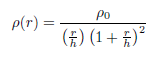

In [19]:
G = 4.302e-6  # (kpc * km^2) / (Msun * s^2)

def ρh_r_nfw(r, ρ0_nfw, h_nfw):
    return ρ0_nfw / ((r / h_nfw)*(1 + r / h_nfw)**2)
  
def Mh_r_nfw(r, ρ0_nfw, h_nfw):
    def integrand_Mh_r(r_):
        return ρh_r_nfw(r_, ρ0_nfw, h_nfw) * r_**2
        
    integral, _ = quad(integrand_Mh_r, 1e-2, r)
    return 4 * np.pi * integral
    
def vh_nfw(r, ρ0_nfw, h_nfw):
    vh2 = G * Mh_r_nfw(r, ρ0_nfw, h_nfw) / r
    if not np.isfinite(vh2) or vh2 <= 0:
        return np.nan
    return np.sqrt(vh2)

## Total theoretical velocity - NFW

In [21]:
def vth_tot_nfw(r, Σb_nfw, a_b_nfw, Σd_nfw, a_d_nfw, ρ0_nfw, h_nfw):
    vb_val = vb_nfw(r, Σb_nfw, a_b_nfw)
    vd_val = vd_nfw(r, Σd_nfw, a_d_nfw)
    vh_val = vh_nfw(r, ρ0_nfw, h_nfw)
    if not all(np.isfinite([vb_val, vd_val, vh_val])):
        return np.nan
    return np.sqrt(vb_val**2 + vd_val**2 + vh_val**2)

## **Using Bayesian Statistics**

In [ ]:
def log_likelihood_nfw(R_array, v_array, sigma_v_array, Σb_nfw, a_b_nfw, Σd_nfw, a_d_nfw, ρ0_nfw, h_nfw):
    vth = np.array([vth_tot_nfw(ri, Σb_nfw, a_b_nfw, Σd_nfw, a_d_nfw, ρ0_nfw, h_nfw) for ri in R_array])
    if not np.all(np.isfinite(vth)):
        return -np.inf
    a = (vth - v_array) / sigma_v_array
    return -(1/2) * np.sum(a**2)

In [ ]:
def uniform_priors_nfw(Σb_nfw, a_b_nfw, Σd_nfw, a_d_nfw, ρ0_nfw, h_nfw):
    if 1 < a_b_nfw < 1.6 and 0.6e9 < Σb_nfw < 0.9e9 and 3 < a_d_nfw < 7 and 0.4e9 < Σd_nfw < 1e9 and 0.5e7 < ρ0_nfw < 1.5e7 and 10 < h_nfw < 25:
        return 0.0
    return -np.inf

In [ ]:
def log_posterior_nfw(theta):
    Σb_nfw, a_b_nfw, Σd_nfw, a_d_nfw, ρ0_nfw, h_nfw = theta
    lp = uniform_priors_nfw(Σb_nfw, a_b_nfw, Σd_nfw, a_d_nfw, ρ0_nfw, h_nfw)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_nfw(R_array, v_array, sigma_v_array, Σb_nfw, a_b_nfw, Σd_nfw, a_d_nfw, ρ0_nfw, h_nfw)
    return lp + ll

In [ ]:
def chi2_nfw(theta):
    Σb_nfw, a_b_nfw, Σd_nfw, a_d_nfw, ρ0_nfw, h_nfw = theta
    return -2 * log_posterior_nfw(theta)

## Running the optimiser

In [ ]:
initial_guesses_nfw = [0.710e9, 1.280, 0.715e9, 4.388, 1.113e7, 16.855]
result = optimize.minimize(chi2_nfw, initial_guesses_nfw, method='nelder-mead',options={'maxiter':10000,'xatol': 1e-8, 'disp': True})

In [ ]:
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

## MCMC using emcee

In [ ]:
ndimension = 6
no_of_walkers = 40
no_of_steps_per_walker = 5000
burn_in_steps = 500

In [ ]:
initial_pos_of_walker = [result.x + 1e-4*np.random.randn(ndimension) for i in range(no_of_walkers)]        #randn gives samples from SND
print(initial_pos_of_walker)

In [ ]:
sampler = emcee.EnsembleSampler(no_of_walkers, ndimension, log_posterior_nfw, a=2)
print(sampler)

In [ ]:
sampler.run_mcmc(initial_pos_of_walker, no_of_steps_per_walker, rstate0=np.random.get_state(),progress=True);     #progress for progress bar

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,0]       # Samples of Σb from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to Σb for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to Σb", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,1]       # Samples of a_b from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to a_b for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to a_b", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,2]       # Samples of Σd from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to Σd for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to Σd", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,3]       # Samples of a_d from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to a_d for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to a_d", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,4]       # Samples of ρ0 from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to ρ0 for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to ρ0", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,5]       # Samples of h from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to h for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to h", dpi=300, bbox_inches = 'tight')

## Corner plots

In [ ]:
samples = sampler.chain[:, burn_in_steps:, :].reshape((-1, ndimension))

In [ ]:
samples = sampler.chain[:, burn_in_steps:, :].reshape((-1, ndimension))

param_labels = [r"$\Sigma_b$", r"$a_b$", r"$\Sigma_d$", r"$a_d$", r"$\rho_0$", r"$h$"]
fig = corner.corner(samples, bins=50, labels=param_labels,
                    color="red",
                    quantiles=[0.16, 0.5, 0.84],
                    plot_contours=True,
                    fill_contours=True,
                    levels=(0.68, 0.95, 0.99),
                    plot_datapoints=True,
                    smooth=True, smooth1d=True,
                    title_fmt=".2g",
                    show_titles=True)

plt.show()
fig.savefig("Corner plot", dpi=300, bbox_inches='tight')

# **Hernquist Profile**

## **Bulge**

In [23]:
k = 7.6695
G = 4.302e-6  # (kpc * km^2) / (Msun * s^2)

def Σbr_x(x, Σb_hernquist, a_b_hernquist):
    return Σb_hernquist * np.exp(-k * ((x / a_b_hernquist)**0.25 - 1))

def dΣbr_x_dx(x, Σb_hernquist, a_b_hernquist):
    prefactor = -(k / 4) * (1 / a_b_hernquist)**0.25 * x**(-0.75)
    return prefactor * Σbr_x(x, Σb_hernquist, a_b_hernquist)

def ρb_r_hernquist(r, Σb_hernquist, a_b_hernquist):
    def integrand_ρb_r(u):
        x = r * np.cosh(u)
        return dΣbr_x_dx(x, Σb_hernquist, a_b_hernquist)
    integral, _ = quad(integrand_ρb_r, 1e-2, 20)
    return -integral / np.pi
    
def vb_hernquist(r, Σb_hernquist, a_b_hernquist):
    def integrand_vb2_r(r_):
        return ρb_r_hernquist(r_, Σb_hernquist, a_b_hernquist) * r_**2

    integral, _ = quad(integrand_vb2_r, 1e-2, r)
    vb2 = (4 * np.pi * G / r) * integral
    if not np.isfinite(vb2) or vb2 <= 0:
        return np.nan
    return np.sqrt(vb2)

## **Disk**

In [25]:
G = 4.302e-6  # (kpc * km^2) / (Msun * s^2)

def vd_hernquist(r, Σd_hernquist, a_d_hernquist):
    y = r / (2 * a_d_hernquist)
    constant = np.pi * G * Σd_hernquist * (r**2 / a_d_hernquist)
    bessel_term = iv(0, y) * kv(0, y) - iv(1, y) * kv(1, y)
    vd2 = constant * bessel_term
    if not np.isfinite(vd2) or vd2 <= 0:
        return np.nan
    return np.sqrt(vd2)

## **Dark matter halo - Hernquist Model**

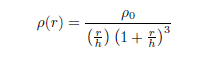

In [27]:
G = 4.302e-6  # (kpc * km^2) / (Msun * s^2)

def ρh_r_hernquist(r, ρ0_hernquist, h_hernquist):
    return ρ0_hernquist / ((r / h_hernquist) * (1 + r / h_hernquist)**3)
  
def Mh_r_hernquist(r, ρ0_hernquist, h_hernquist):
    def integrand_Mh_r(r_):
        return ρh_r_hernquist(r_, ρ0_hernquist, h_hernquist) * r_**2
        
    integral, _ = quad(integrand_Mh_r, 1e-2, r)
    return 4 * np.pi * integral
    
def vh_hernquist(r, ρ0_hernquist, h_hernquist):
    vh2 = G * Mh_r_hernquist(r, ρ0_hernquist, h_hernquist) / r
    if not np.isfinite(vh2) or vh2 <= 0:
        return np.nan
    return np.sqrt(vh2)

## Total theoretical velocity - Hernquist

In [29]:
def vth_tot_hernquist(r, Σb_hernquist, a_b_hernquist, Σd_hernquist, a_d_hernquist, ρ0_hernquist, h_hernquist):
    vb_val = vb_hernquist(r, Σb_hernquist, a_b_hernquist)
    vd_val = vd_hernquist(r, Σd_hernquist, a_d_hernquist)
    vh_val = vh_hernquist(r, ρ0_hernquist, h_hernquist)
    if not all(np.isfinite([vb_val, vd_val, vh_val])):
        return np.nan
    return np.sqrt(vb_val**2 + vd_val**2 + vh_val**2)

## **Using Bayesian statistics**

In [ ]:
def log_likelihood_hernquist(R_array, v_array, sigma_v_array, Σb_hernquist, a_b_hernquist, Σd_hernquist, a_d_hernquist, ρ0_hernquist, h_hernquist):
    vth = np.array([vth_tot_hernquist(ri, Σb_hernquist, a_b_hernquist, Σd_hernquist, a_d_hernquist, ρ0_hernquist, h_hernquist) for ri in R_array])
    if not np.all(np.isfinite(vth)):
        return -np.inf
    a = (vth - v_array) / sigma_v_array
    return -(1/2) * np.sum(a**2)

In [ ]:
def uniform_priors_hernquist(Σb_hernquist, a_b_hernquist, Σd_hernquist, a_d_hernquist, ρ0_hernquist, h_hernquist):
    if 0.5 < a_b_hernquist < 2.0 and 0.5e9 < Σb_hernquist < 1.5e9 and 7 < a_d_hernquist < 12 and 0.2e9 < Σd_hernquist < 0.8e9 and 9e7 < ρ0_hernquist < 11e7 and 1 < h_hernquist < 6:
        return 0.0
    return -np.inf

In [ ]:
def log_posterior_hernquist(theta):
    Σb_hernquist, a_b_hernquist, Σd_hernquist, a_d_hernquist, ρ0_hernquist, h_hernquist = theta
    lp = uniform_priors_hernquist(Σb_hernquist, a_b_hernquist, Σd_hernquist, a_d_hernquist, ρ0_hernquist, h_hernquist)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_hernquist(R_array, v_array, sigma_v_array, Σb_hernquist, a_b_hernquist, Σd_hernquist, a_d_hernquist, ρ0_hernquist, h_hernquist)
    return lp + ll

In [ ]:
def chi2_hernquist(theta):
    Σb_hernquist, a_b_hernquist, Σd_hernquist, a_d_hernquist, ρ0_hernquist, h_hernquist = theta
    return -2 * log_posterior_hernquist(theta)

## Running the optimiser

In [ ]:
initial_guesses_hernquist = [0.713e9, 1.252, 0.439e9, 4.814, 1.799e7, 18.833]
result = optimize.minimize(chi2_hernquist, initial_guesses, method='nelder-mead',options={'maxiter':10000,'xatol': 1e-8, 'disp': True})

In [ ]:
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

## MCMC using emcee

In [ ]:
ndimension = 6
no_of_walkers = 40
no_of_steps_per_walker = 5000
burn_in_steps = 500

In [ ]:
initial_pos_of_walker = [result.x + 1e-4*np.random.randn(ndimension) for i in range(no_of_walkers)]        #randn gives samples from SND
print(initial_pos_of_walker)

In [ ]:
sampler = emcee.EnsembleSampler(no_of_walkers, ndimension, log_posterior_hernquist, a=2)
print(sampler)

In [ ]:
sampler.run_mcmc(initial_pos_of_walker, no_of_steps_per_walker, rstate0=np.random.get_state(),progress=True);     #progress for progress bar

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,0]       # Samples of Σb from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to Σb for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to Σb", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,1]       # Samples of a_b from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to a_b for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to a_b", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,2]       # Samples of Σd from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to Σd for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to Σd", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,3]       # Samples of a_d from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to a_d for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to a_d", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,4]       # Samples of ρ0 from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to ρ0 for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to ρ0", dpi=300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()

for i in range(no_of_walkers):
  a = sampler.chain[i,burn_in_steps:,5]       # Samples of h from walker i
  l = len(a)
  n = list(range(l))
  ax.plot(n,a)

ax.set_title(f"Markov Chains corresponding to h for {no_of_steps_per_walker} steps")
plt.show()

fig.savefig("Markov Chains corresponding to h", dpi=300, bbox_inches = 'tight')

## Corner plots

In [ ]:
samples = sampler.chain[:, burn_in_steps:, :].reshape((-1, ndimension))

In [ ]:
samples = sampler.chain[:, burn_in_steps:, :].reshape((-1, ndimension))

param_labels = [r"$\Sigma_b$", r"$a_b$", r"$\Sigma_d$", r"$a_d$", r"$\rho_0$", r"$h$"]
fig = corner.corner(samples, bins=50, labels=param_labels,
                    color="red",
                    quantiles=[0.16, 0.5, 0.84],
                    plot_contours=True,
                    fill_contours=True,
                    levels=(0.68, 0.95, 0.99),
                    plot_datapoints=True,
                    smooth=True, smooth1d=True,
                    title_fmt=".2g",
                    show_titles=True)

plt.show()
fig.savefig("Corner plot", dpi=300, bbox_inches='tight')